In [2]:
# PennyLane imports
import pennylane as qml
from pennylane import numpy as pnp

from scipy.optimize import minimize

# General imports
import os
import json
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from qiskit.quantum_info import SparsePauliOp

# custom module
from susy_qm import calculate_Hamiltonian, create_vqd_plots

In [17]:
potential = 'QHO'
#potential = 'AHO'
#potential = 'DW'
cut_off = 8

In [18]:
#calculate Hamiltonian and expected eigenvalues
H = calculate_Hamiltonian(cut_off, potential)
eigenvalues = np.sort(np.linalg.eig(H)[0])
min_eigenvalue = min(eigenvalues.real)

#create qiskit Hamiltonian Pauli string
hamiltonian = SparsePauliOp.from_operator(H)
num_qubits = hamiltonian.num_qubits

In [19]:
num_qubits

4

In [20]:
#Initial params shape
num_layers = 1
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=num_qubits)

In [21]:
def ansatz(params, wires):
    params = pnp.tensor(params.reshape(params_shape), requires_grad=True)
    qml.StronglyEntanglingLayers(weights=params, wires=wires, imprimitive=qml.CZ)

In [22]:
# Device
shots = None
dev = qml.device('lightning.qubit', wires=2*num_qubits+1, shots=shots)

@qml.qnode(dev)
def swap_test(params1, params2):

    params1 = pnp.tensor(params1.reshape(params_shape), requires_grad=True)
    params2 = pnp.tensor(params2.reshape(params_shape), requires_grad=True)

    ancilla = 2*num_qubits
    qml.Hadamard(wires=ancilla)

    ansatz(params1, wires=range(num_qubits))
    ansatz(params2, wires=range(num_qubits, 2*num_qubits))

    qml.Barrier()
    for i in range(num_qubits):
        qml.CSWAP(wires=[ancilla, i, num_qubits + i])

    qml.Hadamard(wires=ancilla)

    return qml.probs(wires=ancilla)

In [23]:
# Example parameters for testing the swap test
params1 = np.random.uniform(0, 2 * np.pi, size=qml.StronglyEntanglingLayers.shape(1, num_qubits))
params2 = np.random.uniform(0, 2 * np.pi, size=qml.StronglyEntanglingLayers.shape(1, num_qubits))

# Run the swap test to get the probability of the ancilla being |0>
result = swap_test(params1, params2)

# The overlap is given by 2 * P(ancilla=0) - 1
#overlap = 2 * result[0] - 1
overlap = 1 - 2*result[1]

print(qml.draw(swap_test)(params1,params2))
print(f"\nOverlap between the ground state and the ansatz: {overlap}")

0: ──Rot(5.29,2.25,3.35)─╭●───────╭Z──||─╭SWAP──────────────────────┤       
1: ──Rot(5.37,4.85,5.90)─╰Z─╭●────│───||─│─────╭SWAP────────────────┤       
2: ──Rot(2.29,1.21,3.95)────╰Z─╭●─│───||─│─────│─────╭SWAP──────────┤       
3: ──Rot(4.12,4.79,5.02)───────╰Z─╰●──||─│─────│─────│─────╭SWAP────┤       
4: ──Rot(1.83,3.74,2.67)─╭●───────╭Z──||─├SWAP─│─────│─────│────────┤       
5: ──Rot(0.36,5.88,2.54)─╰Z─╭●────│───||─│─────├SWAP─│─────│────────┤       
6: ──Rot(2.97,2.38,4.04)────╰Z─╭●─│───||─│─────│─────├SWAP─│────────┤       
7: ──Rot(3.87,3.81,5.01)───────╰Z─╰●──||─│─────│─────│─────├SWAP────┤       
8: ──H────────────────────────────────||─╰●────╰●────╰●────╰●─────H─┤  Probs

Overlap between the ground state and the ansatz: 0.11939820255042621


In [24]:
# Device
shots = None
dev2 = qml.device('lightning.qubit', wires=num_qubits, shots=shots)

@qml.qnode(dev2)
def expected_value(params):
    wires = range(num_qubits)
    ansatz(params, wires)
    return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))


def loss_f(params):
    global prev_param_list, beta
    energy = expected_value(params)

    penalty = 0

    if len(prev_param_list) != 0:
        for prev_param in prev_param_list:
            overlap =  1 - (2*swap_test(prev_param, params)[1])
            penalty += (beta*overlap)

    return energy + (penalty)

In [25]:
def callback(xk):
    global iteration_counter, counts, values
    
    current_cost = loss_f(xk)

    iteration_counter += 1
    counts.append(iteration_counter) 
    values.append(current_cost)

In [26]:
vqd_start = datetime.now()

#variables
num_vqd_runs = 4
max_iterations = 10000
beta = 2.0
tolerance = 1e-6

#data arrays
energies = []
prev_param_list = []
num_iters = []
run_times = []
success = []
run_times = []

all_counts = []
all_values = []
all_overlaps = []

#Initial params
scale = 0.5
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=num_qubits)
params = scale*np.pi * pnp.random.random(size=np.prod(params_shape))

for i in range(num_vqd_runs):

    run_start = datetime.now()

    iteration_counter = 0
    counts = []
    values = []    

    if i % 1 == 0:
        print(f"Run: {i}")


    res = minimize(loss_f,
                   x0=params,
                   method='COBYLA',
                   options={'maxiter': max_iterations, 'tol':tolerance},
                   callback=callback)
    
    all_counts.append(counts)
    all_values.append(values)        


    energies.append(res.fun)
    prev_param_list.append(res.x) 
    num_iters.append(res.nfev)
    success.append(res.success)

    run_end = datetime.now()
    run_time = run_end - run_start
    run_times.append(run_time)

    print(energies)

    # Calculate overlap with all previous states
    overlaps = []
    if i > 0:
        for j in range(i):
            overlap =  1 - (2*swap_test(prev_param_list[j], params)[1])
            overlaps.append(overlap)
        all_overlaps.append(overlaps)
        print(f"Overlaps with all previous states for run {i}: {overlaps}")

vqd_end = datetime.now()
vqd_time = vqd_end - vqd_start


Run: 0
[np.float64(1.7253996151643999e-13)]
Run: 1
[np.float64(1.7253996151643999e-13), np.float64(1.0000000000000973)]
Overlaps with all previous states for run 1: [np.float64(0.20526251199478907)]
Run: 2
[np.float64(1.7253996151643999e-13), np.float64(1.0000000000000973), np.float64(1.0000000000002234)]
Overlaps with all previous states for run 2: [np.float64(0.20526251199478907), np.float64(0.5395561483921483)]
Run: 3
[np.float64(1.7253996151643999e-13), np.float64(1.0000000000000973), np.float64(1.0000000000002234), np.float64(1.9999998558847885)]
Overlaps with all previous states for run 3: [np.float64(0.20526251199478907), np.float64(0.5395561483921483), np.float64(0.008565858912633062)]


In [27]:
#Save run
run = {
    'potential': potential,
    'cutoff': cut_off,
    'exact_eigenvalues': [round(x.real,10).tolist() for x in eigenvalues],
    'ansatz': 'StronglyEntanglingLayers-1layer',
    'num_VQD': num_vqd_runs,
    'Optimizer': {'name': 'COBYLA',
                'maxiter':max_iterations,
                'tolerance': tolerance
                },
    'converged_energies': energies,
    'converged_params': [x.tolist() for x in prev_param_list],
    'energies': all_values,
    'num_iters': all_counts,
    'success': np.array(success, dtype=bool).tolist(),
    'run_times': [str(x) for x in run_times],
    'total_run_time': str(vqd_time)
}

# Save the variable to a JSON file

starttime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
folder = str(starttime)
#Create directory for files
base_path = r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\PennyLane\VQD\COBYLA\Files\{}\\{}\\".format(potential, folder)
os.makedirs(base_path)

path = base_path + "{}_{}.json".format(potential, cut_off)
with open(path, 'w') as json_file:
    json.dump(run, json_file, indent=4)

In [28]:
file_path = path
with open(file_path, 'r') as json_file:
    data = json.load(json_file)

In [29]:
data

{'potential': 'QHO',
 'cutoff': 8,
 'exact_eigenvalues': [0.0,
  1.0,
  1.0,
  2.0,
  2.0,
  3.0,
  3.0,
  3.0,
  4.0,
  4.0,
  4.0,
  5.0,
  5.0,
  6.0,
  6.0,
  7.0],
 'ansatz': 'StronglyEntanglingLayers-1layer',
 'num_VQD': 4,
 'Optimizer': {'name': 'COBYLA', 'maxiter': 10000, 'tolerance': 1e-06},
 'converged_energies': [1.7253996151643999e-13,
  1.0000000000000973,
  1.0000000000002234,
  1.9999998558847885],
 'converged_params': [[1.6362669210667828,
   3.1415922433075765,
   1.7001805470113716,
   0.019402801704057827,
   -4.3498188850010365e-08,
   0.40782101252059216,
   1.847886483995273,
   -1.472741070317238e-07,
   2.1185191278826068,
   1.2129888201956276,
   -6.8620744220177e-07,
   0.5405818904884199],
  [1.0273354132322943,
   -3.6572496994788397e-07,
   0.779718526825552,
   2.0172181247864978,
   -2.1184726599857266e-07,
   0.31243107761049765,
   0.9751838123745715,
   -2.1752989247218166e-07,
   2.293906750450293,
   1.9785593476206378,
   -9.22347758259133e-08,
   

Creating plots
Saving plots
Done


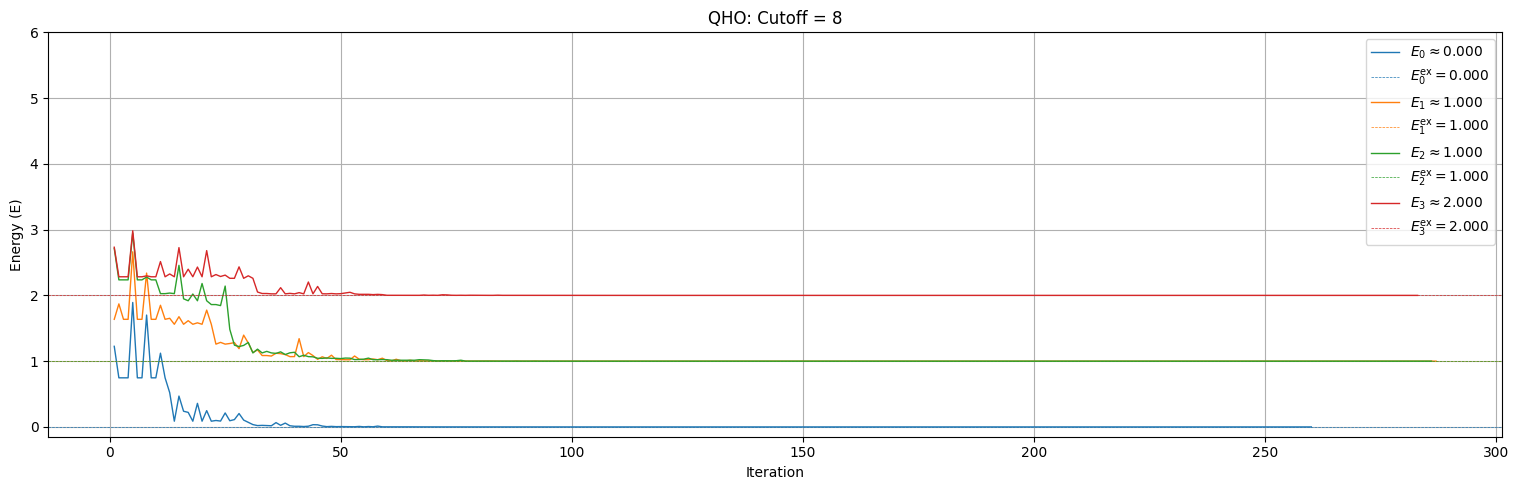

In [30]:
cut_off_list = [8]#[2,4,8,16,32]
create_vqd_plots(potential, base_path, cut_off_list)

In [ ]:
# Plotting each line for different states
plt.figure(figsize=(15, 10))  # Set figure size similar to the uploaded image

for i in range(data['num_VQD']):
    line, = plt.plot(data['num_iters'][i], data['energies'][i], linewidth=1.0, label=f"$E_{{{i}}} \\approx {data['converged_energies'][i]:.3f}$")
    plt.axhline(data['exact_eigenvalues'][i], color = line.get_color(), linestyle='--', linewidth=0.5, label=f"$E_{{{i}}}^{{\\text{{ex}}}} = {data['exact_eigenvalues'][i]:.3f}$")

# Set axis labels and title
plt.xlabel("Iteration")
plt.ylabel("Energy (E)")
plt.title("Energy Convergence for Each Computed State")
plt.title(f"{potential}: Cutoff = {data['cutoff']}")

plt.ylim(None, 6)

plt.legend(loc="upper right")

# Show plot
#plt.show()
plt.savefig('VQD-DW-4')


In [ ]:
base_path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\SUSY\PennyLane\VQD\COBYLA\Files\{}\\{}\\"
folder = "2024-11-13_21-34-45"
cut_off_list = [2,4,8]

def create_vqd_plots(potential, base_path, folder, cut_off_list):

    # Load all data and create graphs
    print("Creating plots")
    data_dict = {}

    for n in cut_off_list:
        file_path = base_path.format(potential, folder) + potential + "_" + str(n) + ".json"
        with open(file_path, 'r') as json_file:
            data_dict[f'c{n}'] = json.load(json_file)


    #Create and save plots
    num_cutoffs = len(cut_off_list)
    nrows = int(np.ceil(num_cutoffs/2))
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(30, 5*nrows))
    axes = axes.flatten()

    for idx, (cutoff, data) in enumerate(data_dict.items()):
        
        # Creating the plot
        ax = axes[idx]

        for i in range(data['num_VQD']):
            line, = ax.plot(data['num_iters'][i], data['energies'][i], linewidth=1.0, label=f"$E_{{{i}}} \\approx {data['converged_energies'][i]:.3f}$")
            ax.axhline(data['exact_eigenvalues'][i], color = line.get_color(), linestyle='--', linewidth=0.5, label=f"$E_{{{i}}} = {data['exact_eigenvalues'][i]:.3f}$")

        ax.set_xlabel("Iteration")
        ax.set_ylabel("Energy (E)")
        ax.set_title(f"{potential}: Cutoff = {data['cutoff']}")

        ax.set_ylim(None, 6)

        ax.legend(loc="upper right")
        ax.grid(True)

    # Hide any remaining unused axes
    for idx in range(num_cutoffs, len(axes)):
        fig.delaxes(axes[idx])

    print("Saving plots")
    plt.tight_layout()
    plt.savefig(base_path.format(potential, folder) + "results.png")

    print("Done")

In [ ]:

potential = 'AHO'
cut_off_list = [2,4,8,16,32]
folder = '2024-11-13_23-01-58'
base_path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\SUSY\PennyLane\VQD\COBYLA\Files\AHO\\2024-11-13_23-01-58\\"

# Load all data and create graphs
print("Creating plots")
data_dict = {}

for n in cut_off_list:
    file_path = base_path + potential + "_" + str(n) + ".json"
    with open(file_path, 'r') as json_file:
        data_dict[f'c{n}'] = json.load(json_file)


#Create and save plots
num_cutoffs = len(cut_off_list)
nrows = int(np.ceil(num_cutoffs/2))
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(30, 5*nrows))
axes = axes.flatten()

for idx, (cutoff, data) in enumerate(data_dict.items()):
    
    # Creating the plot
    ax = axes[idx]

    for i in range(data['num_VQD']):
        line, = ax.plot(data['num_iters'][i], data['energies'][i], linewidth=1.0, label=f"$E_{{{i}}} \\approx {data['converged_energies'][i]:.3f}$")
    
    #for i in range(len(data['exact_eigenvalues'])):
    #    ax.axhline(data['exact_eigenvalues'][i], color = line.get_color(), linestyle='--', linewidth=0.5, label=f"$E_{{{i}}}^{{\\text{{ex}}}} = {data['exact_eigenvalues'][i]:.3f}$")

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Energy (E)")
    ax.set_title(f"{potential}: Cutoff = {data['cutoff']}")

    #ax.set_ylim(None, 6)

    ax.legend(loc="upper right")
    ax.grid(True)

# Hide any remaining unused axes
for idx in range(num_cutoffs, len(axes)):
    fig.delaxes(axes[idx])

print("Saving plots")
plt.tight_layout()
plt.show()

print("Done")

In [ ]:
data